# Cleaning Intel Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_style('whitegrid')

# Cleaning

Stock data we downloaded from Marketwatch and then put together in a Google Sheet which we then downloaded for the past 15 years

In [3]:
intel_stock = pd.read_csv("IntelStockData.csv")
intel_stock.head()

,Date,Open,High,Low,Close,Volume
0,1/2/2026,37.77,39.86,37.76,39.38,"95,396,445"
1,12/31/2025,37.40,37.58,36.87,36.90,"51,524,680"
2,12/30/2025,36.91,38.26,36.82,37.30,"61,935,281"
3,12/29/2025,36.01,36.80,35.82,36.68,"38,062,301"
4,12/26/2025,36.17,36.49,35.85,36.20,"28,779,400"


Analyst data that we retrieved from the Google BigQuery; I am limiting to Intel because that is the company I am working on

In [4]:
analyst_data = pd.read_csv("AllAnalystData.csv", dtype={'price_target_before': str, 'price_target_after':str})
analyst_data = analyst_data.iloc[:,0:9]
intel_analyst_data = analyst_data[analyst_data.iloc[:,2] == "INTC"]
intel_analyst_data.head()

,date,company_Name,ticker,broker,analytst,rating_before,rating_after,price_target_before,price_target_after
835,7/6/2020,Intel Corp,INTC,NaN,JAMES COVELLO,Neutral,Sell,65,54
836,4/15/2021,Intel Corp,INTC,NaN,CHRIS CASO,Mkt Perform,Underperf,NaN,NaN
837,1/25/2019,Intel Corp,INTC,WELLS FARGO,AARON RAKERS,NaN,OUTPERFORM,NaN,55
838,5/9/2019,Intel Corp,INTC,WELLS FARGO,AARON RAKERS,,NEGATIVE,60,55
839,4/24/2020,Intel Corp,INTC,WELLS FARGO,AARON RAKERS,,EQUAL WEIGHT,56,60


Cleaning instances where a special arrow character is used so that I can fully clean all NA's later

In [5]:
intel_analyst_data.iloc[:,7] = intel_analyst_data.iloc[:,7].replace('70 » 60         ', 70)
intel_analyst_data.iloc[:,8] = intel_analyst_data.iloc[:,8].replace('70 » 60', 60)

intel_analyst_data.iloc[:,7] = intel_analyst_data.iloc[:,7].replace('50 » 53         ', 50)
intel_analyst_data.iloc[:,8] = intel_analyst_data.iloc[:,8].replace('50 » 53', 53)

intel_analyst_data.iloc[:,7] = intel_analyst_data.iloc[:,7].replace('50 » 45         ', 50)
intel_analyst_data.iloc[:,8] = intel_analyst_data.iloc[:,8].replace('50 » 45', 45)

intel_analyst_data.iloc[:,7] = intel_analyst_data.iloc[:,7].replace('47 » 48         ', 47)
intel_analyst_data.iloc[:,8] = intel_analyst_data.iloc[:,8].replace('47 » 48', 48)

intel_analyst_data.iloc[:,7] = intel_analyst_data.iloc[:,7].replace('58 » 60         ', 58)
intel_analyst_data.iloc[:,8] = intel_analyst_data.iloc[:,8].replace('58 » 60', 60)

Command to replace the empty cells with NaN values so I can now filter DataFrame 

In [6]:
intel_analyst_data.iloc[:,7] = intel_analyst_data.iloc[:,7].str.strip().replace('',np.nan)
intel_analyst_data.iloc[:,8] = intel_analyst_data.iloc[:,8].str.strip().replace('',np.nan)

Taking out all rows that have an NaN in price_target_after

In [7]:
intel_nas = intel_analyst_data.isna()
clean_intel = intel_analyst_data[intel_nas.iloc[:,8] == False]

This renamed the analyst column in the Analyst data correctly and also made the date column in datetime values

In [8]:
clean_analyst_data = clean_intel.rename(columns={'analytst':'analyst'})
clean_analyst_data['date'] = pd.to_datetime(clean_analyst_data['date'])

This renamed the date column in the Stock data correctly, made the date column in datetime values and created a variable for the necessary stock data columns

In [9]:
intel_stock = intel_stock.rename(columns={'Date':'date'})
intel_stock['date'] = pd.to_datetime(intel_stock['date'])
intel_stock_data_needed = intel_stock[['date', 'Close', 'High', 'Low']]

Sorting analyst data by date to merge with stock data

In [10]:
analyst_data_date_sort = clean_analyst_data.sort_values(by='date', ascending=False)

# Combining Clean Analyst Data and Stock Data

Merging analyst data and Intel stock data

In [11]:
intel_data = pd.merge(left=analyst_data_date_sort, right=intel_stock_data_needed, on='date', how='inner')

Changed price_target_before and price_target_after to float values for computation later

In [12]:
intel_data[["price_target_before","price_target_after"]] = intel_data[["price_target_before","price_target_after"]].astype(float)

In [13]:
intel_data.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,High,Low
0,2025-07-14,Intel Corp,INTC,NaN,TIMOTHY ARCURI,Neutral,Neutral,25.0,25.0,23.30,23.40,22.88
1,2025-07-07,Intel Corp,INTC,NaN,CHRISTOPHER DANELY,Neutral,Neutral,24.0,24.0,22.00,22.39,21.86
2,2025-05-21,Intel Corp,INTC,NaN,ROSS SEYMORE,Hold,Hold,23.0,23.0,20.69,21.63,20.59
3,2025-04-30,Intel Corp,INTC,NaN,KEVIN CASSIDY,Sell,Sell,14.0,14.0,20.10,20.18,19.55
4,2025-04-28,Intel Corp,INTC,WELLS FARGO,AARON RAKERS,NaN,EQUAL WEIGHT,NaN,22.0,20.51,21.08,20.05


Function to calculate how many trading days it took to hit the price target

In [14]:
def days_to_hit_target(analyst_df, price_df):
    price_df = price_df.sort_values("date")

    def compute_days(row):
        start_date = row["date"]
        target = row["price_target_after"]

        future_prices = price_df[price_df["date"] > start_date].sort_values("date")

        if future_prices.empty:
            return np.nan

        if target >= row["Close"]:
            hit = future_prices[future_prices["High"] >= target]

        else:
            hit = future_prices[future_prices["Low"] <= target]

        if hit.empty:
            return np.nan

        hit_date = hit.iloc[0]["date"]
        return len(future_prices[future_prices["date"] <= hit_date])

    analyst_df["days_to_target"] = analyst_df.apply(compute_days, axis=1)
    return analyst_df

In [15]:
intel_days_data = days_to_hit_target(intel_data,intel_stock)

In [16]:
intel_days_data.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,High,Low,days_to_target
0,2025-07-14,Intel Corp,INTC,NaN,TIMOTHY ARCURI,Neutral,Neutral,25.0,25.0,23.30,23.40,22.88,24.0
1,2025-07-07,Intel Corp,INTC,NaN,CHRISTOPHER DANELY,Neutral,Neutral,24.0,24.0,22.00,22.39,21.86,3.0
2,2025-05-21,Intel Corp,INTC,NaN,ROSS SEYMORE,Hold,Hold,23.0,23.0,20.69,21.63,20.59,25.0
3,2025-04-30,Intel Corp,INTC,NaN,KEVIN CASSIDY,Sell,Sell,14.0,14.0,20.10,20.18,19.55,NaN
4,2025-04-28,Intel Corp,INTC,WELLS FARGO,AARON RAKERS,NaN,EQUAL WEIGHT,NaN,22.0,20.51,21.08,20.05,10.0


Calculating the difference between price target and close data -- pt_close_difference values represent how different the analyst expected the stock to rise or drop compared to the current stock price

In [17]:
intel_days_data['pt_close_difference'] = abs(intel_days_data['price_target_after'] - intel_days_data['Close'])
intel_days_data.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after,Close,High,Low,days_to_target,pt_close_difference
0,2025-07-14,Intel Corp,INTC,NaN,TIMOTHY ARCURI,Neutral,Neutral,25.0,25.0,23.30,23.40,22.88,24.0,1.70
1,2025-07-07,Intel Corp,INTC,NaN,CHRISTOPHER DANELY,Neutral,Neutral,24.0,24.0,22.00,22.39,21.86,3.0,2.00
2,2025-05-21,Intel Corp,INTC,NaN,ROSS SEYMORE,Hold,Hold,23.0,23.0,20.69,21.63,20.59,25.0,2.31
3,2025-04-30,Intel Corp,INTC,NaN,KEVIN CASSIDY,Sell,Sell,14.0,14.0,20.10,20.18,19.55,NaN,6.10
4,2025-04-28,Intel Corp,INTC,WELLS FARGO,AARON RAKERS,NaN,EQUAL WEIGHT,NaN,22.0,20.51,21.08,20.05,10.0,1.49


In [18]:
intel_days_data_no_nan = intel_days_data.dropna(subset=['days_to_target'])

Preliminary scatterplot comparing days to hit price target and difference in price target and current stock price

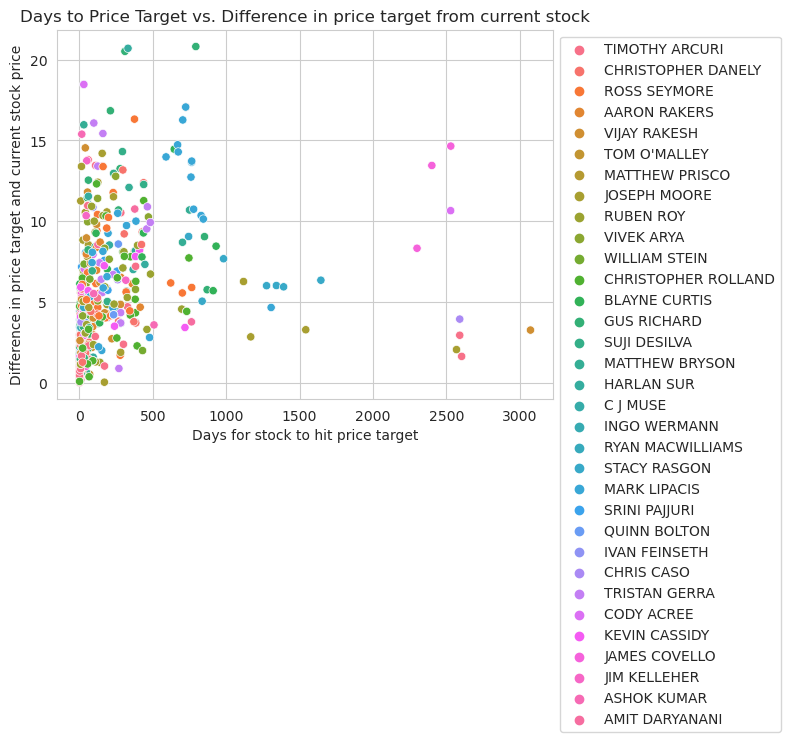

In [19]:
sns.scatterplot(intel_days_data_no_nan, x='days_to_target', y='pt_close_difference', hue='analyst')
plt.title('Days to Price Target vs. Difference in price target from current stock')
plt.xlabel('Days for stock to hit price target')
plt.ylabel('Difference in price target and current stock price')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Creating a new DataFrame that shows the average days_to_target and average pt_close_difference by analyst

In [20]:
analyst_average = intel_days_data_no_nan.groupby('analyst')['days_to_target'].mean().to_frame()
analyst_average['avg_difference'] = intel_days_data_no_nan.groupby('analyst')['pt_close_difference'].mean()

In [21]:
analyst_average = analyst_average.reset_index()

In [22]:
analyst_average.head()

,analyst,days_to_target,avg_difference
0,AARON RAKERS,113.500000,4.637500
1,AMIT DARYANANI,133.000000,3.716000
2,ASHOK KUMAR,338.000000,7.220000
3,BLAYNE CURTIS,171.576923,4.720769
4,C J MUSE,94.800000,5.792000


Scatterplot of average days_to_target on x-axis and average pt_close_difference on the y-axis

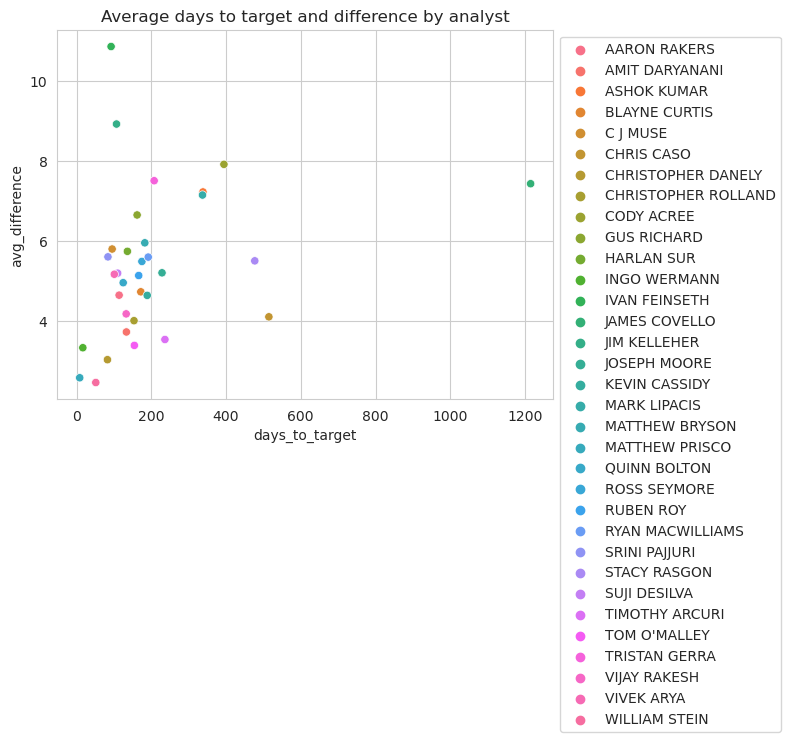

In [23]:
sns.scatterplot(analyst_average, x='days_to_target', y='avg_difference', hue='analyst')
plt.title('Average days to target and difference by analyst')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

Regression plot with all analysts

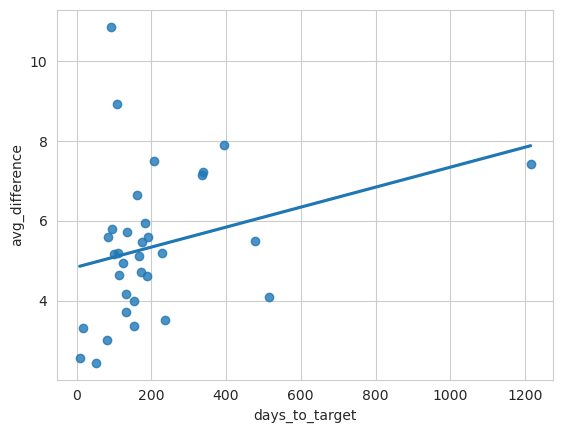

In [24]:
sns.regplot(analyst_average, x='days_to_target', y='avg_difference', ci=None)
plt.show()

Regression plot with analysts within one trading year

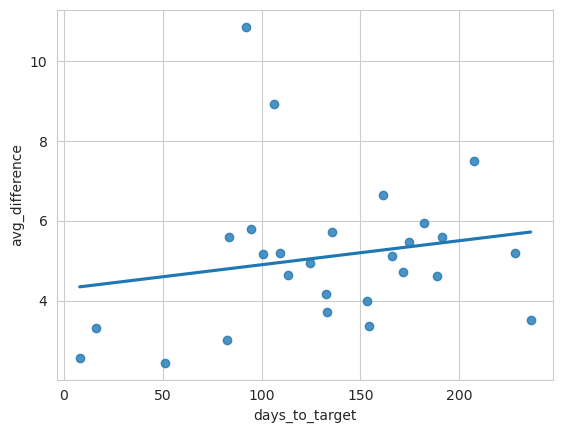

In [25]:
analyst_average_filtered = analyst_average[analyst_average["days_to_target"] <= 252]
sns.regplot(analyst_average_filtered, x="days_to_target", y="avg_difference", ci=None)
plt.show()

Creating a DataFrame for when analysts didn't hit their price targets and making it proportional to the total number of predictions

In [26]:
never_hit_pt = intel_data.groupby('analyst')['days_to_target'].apply(lambda x: x.isna().sum()).to_frame()
never_hit_pt['total_predictions'] = intel_data.groupby('analyst').size()
never_hit_pt['prop'] = never_hit_pt['days_to_target']/never_hit_pt['total_predictions']
never_hit_pt_sorted = never_hit_pt.sort_values('prop')

Dropping the index for never_hit_pt and analyst_average so they can be merged by analyst

In [27]:
never_hit_pt = never_hit_pt_sorted.reset_index().drop('index', axis=1, errors='ignore')
analyst_average = analyst_average.reset_index().drop('index', axis=1, errors='ignore')
merged = pd.merge(left=analyst_average, right=never_hit_pt, on='analyst', how='outer')
merged = merged.rename(columns={'days_to_target_x':'avg_days_to_target', 'days_to_target_y':'num_never_hit_pt'})
merged.head()

,analyst,avg_days_to_target,avg_difference,num_never_hit_pt,total_predictions,prop
0,AARON RAKERS,113.500000,4.637500,3,19,0.157895
1,AMIT DARYANANI,133.000000,3.716000,0,10,0.000000
2,ASHOK KUMAR,338.000000,7.220000,0,4,0.000000
3,BLAYNE CURTIS,171.576923,4.720769,0,26,0.000000
4,C J MUSE,94.800000,5.792000,3,8,0.375000


Bar plot of proportion of price targets that were never reached by analyst

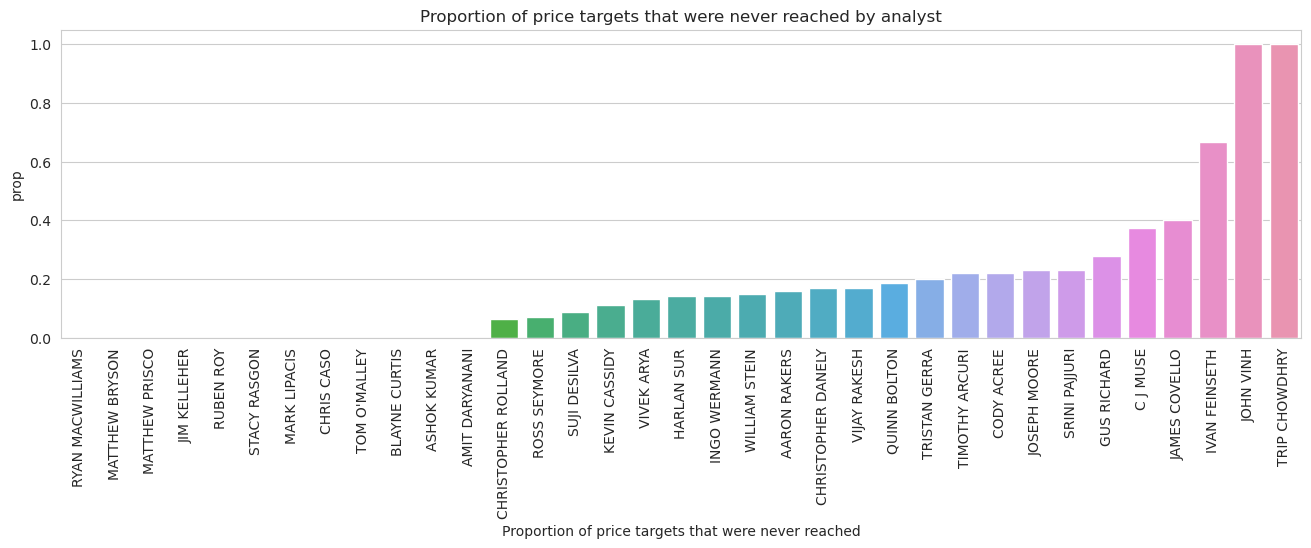

In [28]:
plt.figure(figsize=(16,4))
sns.barplot(never_hit_pt, x='analyst', y='prop')
plt.xticks(rotation=90)
plt.title('Proportion of price targets that were never reached by analyst')
plt.xlabel('Proportion of price targets that were never reached')
plt.show()

Working with all the NASDAQ-100 Tech Companies Data (plus Tesla)

In [29]:
all_tech = pd.read_csv('AllTechCompaniesData.csv')

In [30]:
all_tech = all_tech.rename(columns={'analytst':'analyst'})
all_tech['date'] = pd.to_datetime(all_tech['date'])
all_tech["price_target_after"] = all_tech["price_target_after"].str.strip().replace('',np.nan)
all_tech = all_tech.dropna(subset=["price_target_after"])

In [31]:
all_intel_analysts = all_tech[all_tech['analyst'].str.contains("AARON RAKERS|AMIT DARYANANI|ASHOK KUMAR|BLAYNE CURTIS|C J MUSE|CHRIS CASO|CHRISTOPHER DANELY|CHRISTOPHER ROLLAND|CODY ACREE|GUS RICHARD|HARLAN SUR|INGO WERMANN|IVAN FEINSETH|JAMES COVELLO|JIM KELLEHER|JOSEPH MOORE|KEVIN CASSIDY|MARK LIPACIS|MATTHEW BRYSON|MATTHEW PRISCO|QUINN BOLTON|ROSS SEYMORE|RUBEN ROY|RYAN MACWILLIAMS|SRINI PAJJURI|STACY RASGON|SUJI DESILVA|TIMOTHY ARCURI|TOM O'MALLEY|TRISTAN GERRA|VIJAY RAKESH|VIVEK ARYA|WILLIAM STEIN")]

In [32]:
all_intel_analysts.head()

,date,company_Name,ticker,broker,analyst,rating_before,rating_after,price_target_before,price_target_after
0,2012-08-09,Apple Inc,AAPL,STIFEL,AARON RAKERS,NaN,BUY,NaN,29.46
1,2013-09-06,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,19.29
2,2015-12-11,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,37.5
3,2016-01-22,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,35
4,2016-03-21,Apple Inc,AAPL,STIFEL,AARON RAKERS,BUY,BUY,NaN,30


Simulation to pull 5 random analysts and create three plots

In [35]:
def random_analysts(merged, tech_predictions, n=10, seed=1234): 
    analysts = merged.sample(n=n, random_state=seed).copy()

    counts = (
        tech_predictions
        .groupby('analyst')
        .size()
    )

    analysts['total_predictions_all_companies'] = (
        analysts['analyst']
        .map(counts)
        .fillna(0)
        .astype(int)
    )

    fig, axes = plt.subplots(1, 3, figsize=(16.5,5.5))

    sns.barplot(
        data=analysts, 
        x='analyst', 
        y='total_predictions_all_companies', 
        ax=axes[0]
    )

    sns.barplot(
        data=analysts,
        x='analyst',
        y='prop',
        ax=axes[1]
    )

    sns.scatterplot(
        data=analysts,
        x='avg_days_to_target',
        y='avg_difference',
        hue='analyst',
        ax=axes[2]
    )

    axes[0].tick_params(axis='x', rotation=90)
    axes[1].tick_params(axis='x', rotation=90)
    axes[0].set_ylabel('Number of predictions for tech companies')
    axes[1].set_ylabel('Proportion of price target never hit')
    axes[2].set_xlabel('Avg number of days for price target to be reached')
    axes[2].set_ylabel('Avg difference between price target and stock price')
    plt.legend(bbox_to_anchor=(1.75,1))
    plt.tight_layout()
    plt.show()

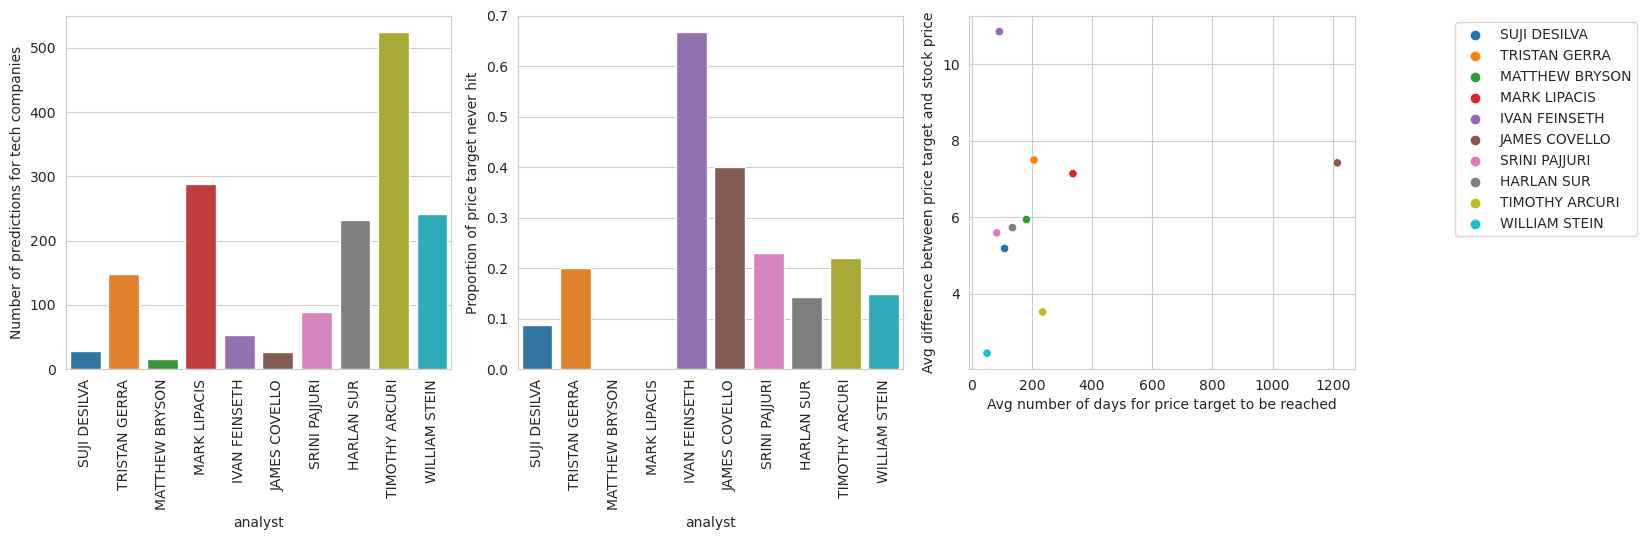

In [36]:
random_analysts(merged, all_intel_analysts, seed=121)

Separation to prevent downloading csv files below multiple times

In [38]:
all_intel_analysts.to_csv('IntelNasdaqTechCompanies.csv',index=False)
merged.to_csv('NeverHitandAnalystAverage.csv',index=False)
analyst_average_filtered.to_csv('OneTradingYearAnalystAverage.csv',index=False)